# Time Series Analysis of NYC Yellow Taxi Trips

In [ ]:
%pip install kagglehub
%pip install pandas
%pip install matplotlib
%pip install numpy
%pip install seaborn
%pip install -U jupyter ipywidgets
%pip install -U jupyterlab-widgets
%pip install statsmodels

import seaborn as sns
from scipy.stats import norm, alpha
import numpy as np
import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt
from datetime import datetime

## Dataset loading

In [ ]:
# Download latest version
path = kagglehub.dataset_download("elemento/nyc-yellow-taxi-trip-data")
# print("Path to dataset files:", path) use only for debug
file_path1 = os.path.join(path, "yellow_tripdata_2015-01.csv")  # Path to the dataset file
file_path2 = os.path.join(path, "yellow_tripdata_2016-01.csv")  # Path to the dataset file
file_path3 = os.path.join(path, "yellow_tripdata_2016-02.csv")  # Path to the dataset file
file_path4 = os.path.join(path, "yellow_tripdata_2016-03.csv")  # Path to the dataset file

In [ ]:
# Columns of interest
columns = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance', 'fare_amount', 'total_amount']

# Load the dataset into a pandas dataframe
df_2015_01 = pd.read_csv(file_path1, usecols=columns, parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])
df_2016_01 = pd.read_csv(file_path2, usecols=columns, parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])
df_2016_02 = pd.read_csv(file_path3, usecols=columns, parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])
df_2016_03 = pd.read_csv(file_path4, usecols=columns, parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

# Concatenate the dataframes
df = pd.concat([df_2015_01, df_2016_01, df_2016_02, df_2016_03], ignore_index=True)

## Data cleaning

In [ ]:
# Remove rows with missing values
df.dropna(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance', 'fare_amount', 'total_amount'], inplace=True)

# Remove trips with negative values
df = df[(df['trip_distance'] > 0) & (df['fare_amount'] > 0) & (df['total_amount'] > 0)]

## Time variables creation

In [ ]:
df['pickup_date'] = df['tpep_pickup_datetime'].dt.date
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
df['pickup_dayofweek'] = df['tpep_pickup_datetime'].dt.dayofweek # Monday=0, Sunday=6

In [ ]:
# Trip duration calculation
df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60  # in minutes

# Remove trips with negative duration or excessive duration (i.e.: more than 4 hours)
df = df[(df['trip_duration'] > 0) & (df['trip_duration'] < 240)]

In [ ]:
# Calculate the average duration of trips for each day
daily_avg_duration = df.groupby('pickup_date')['trip_duration'].mean()

# Visualize the trend of the average trip duration
plt.figure(figsize=(14, 7))
daily_avg_duration.plot()
plt.title('Average trip duration per day')
plt.xlabel('Date')
plt.ylabel('Average trip duration (minutes)')
plt.show()

## Stationarity analysis

In [28]:
daily_trips = df.groupby('pickup_date').size()

ts_daily_trips = daily_trips.copy()
ts_daily_trips.index = pd.to_datetime(ts_daily_trips.index)
ts_daily_trips = ts_daily_trips.asfreq('D', fill_value=0)

In [29]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print(f'Critical Value ({key}): {value}')

test_stationarity(ts_daily_trips)

ADF Statistic: -1.7286526118852887
p-value: 0.4164135181929622
Critical Value (1%): -3.4471856790801514
Critical Value (5%): -2.868960436182993
Critical Value (10%): -2.5707229006220524


In [30]:
ts_daily_trips_diff = ts_daily_trips.diff().dropna()

test_stationarity(ts_daily_trips_diff)

ADF Statistic: -15.182071594471724
p-value: 6.1774522970379055e-28
Critical Value (1%): -3.4471856790801514
Critical Value (5%): -2.868960436182993
Critical Value (10%): -2.5707229006220524


The $p$-value is less than $0.05$, which means that we can reject the null hypothesis that the time series is non-stationary. The time series is stationary.

## ARIMA-SARIMA models
### p, d, q parameters

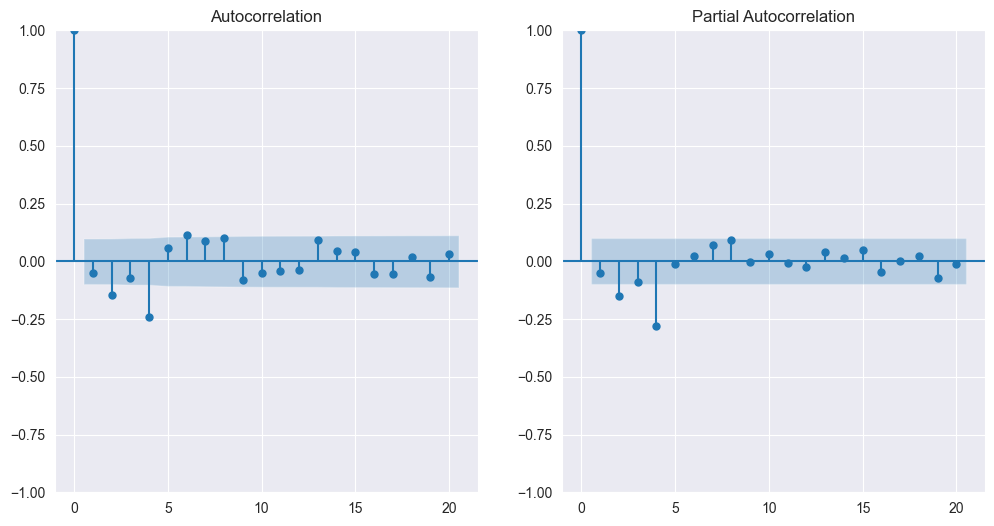

In [31]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(ts_daily_trips_diff, ax=plt.gca(), lags=20)
plt.subplot(122)
plot_pacf(ts_daily_trips_diff, ax=plt.gca(), lags=20)
plt.show()

In [34]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(ts_daily_trips_diff, order=(1,1,1))

model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  395
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4770.060
Date:                Sat, 09 Nov 2024   AIC                           9546.121
Time:                        14:52:40   BIC                           9558.050
Sample:                    01-02-2015   HQIC                          9550.848
                         - 01-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0521      0.059     -0.890      0.373      -0.167       0.063
ma.L1         -0.9941      0.013    -75.062      0.000      -1.020      -0.968
sigma2      2.578e+09   9.38e-12   2.75e+20      0.0

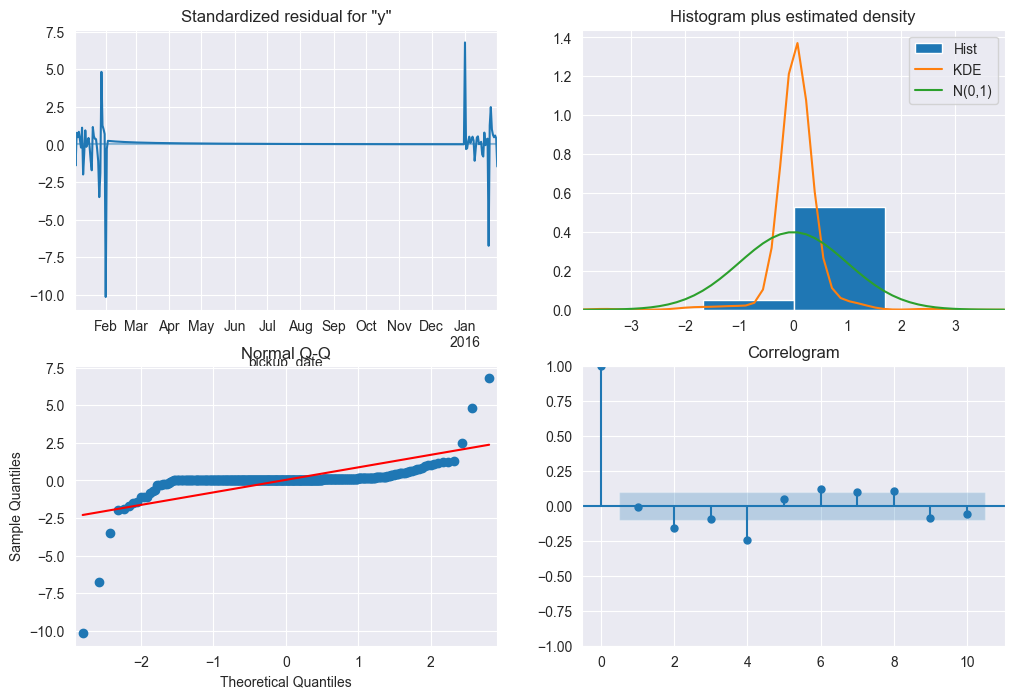

In [36]:
# Diagnostic plots
model_fit.plot_diagnostics(figsize=(12,8))
plt.show()

2016-02-01    5313.273459
2016-02-02    1195.469894
2016-02-03    1410.146699
2016-02-04    1398.954779
2016-02-05    1399.538256
2016-02-06    1399.507837
2016-02-07    1399.509423
Freq: D, Name: predicted_mean, dtype: float64


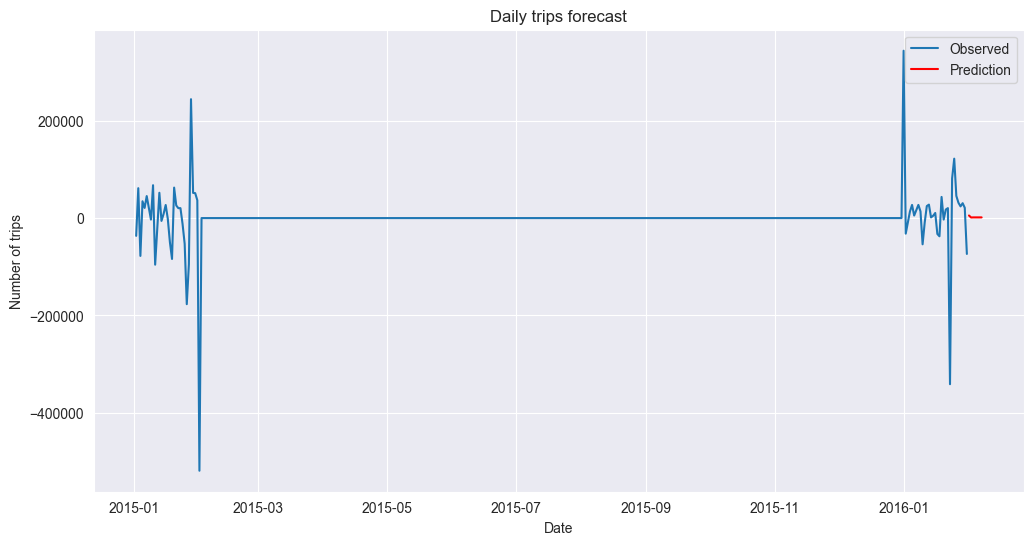

In [37]:
# Forecast
forecast = model_fit.forecast(steps=7)
print(forecast)

plt.figure(figsize=(12,6))
plt.plot(ts_daily_trips_diff, label='Observed')
plt.plot(forecast.index, forecast.values, label='Prediction', color='red')
plt.title('Daily trips forecast')
plt.xlabel('Date')
plt.ylabel('Number of trips')
plt.legend()
plt.show()

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  395
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -4740.233
Date:                           Sat, 09 Nov 2024   AIC                           9490.467
Time:                                   14:53:31   BIC                           9510.259
Sample:                               01-02-2015   HQIC                          9498.315
                                    - 01-31-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0606      0.088     -0.688      0.491      -0.233       0.112
ma.L1         -0.9892      0.059    -16.875

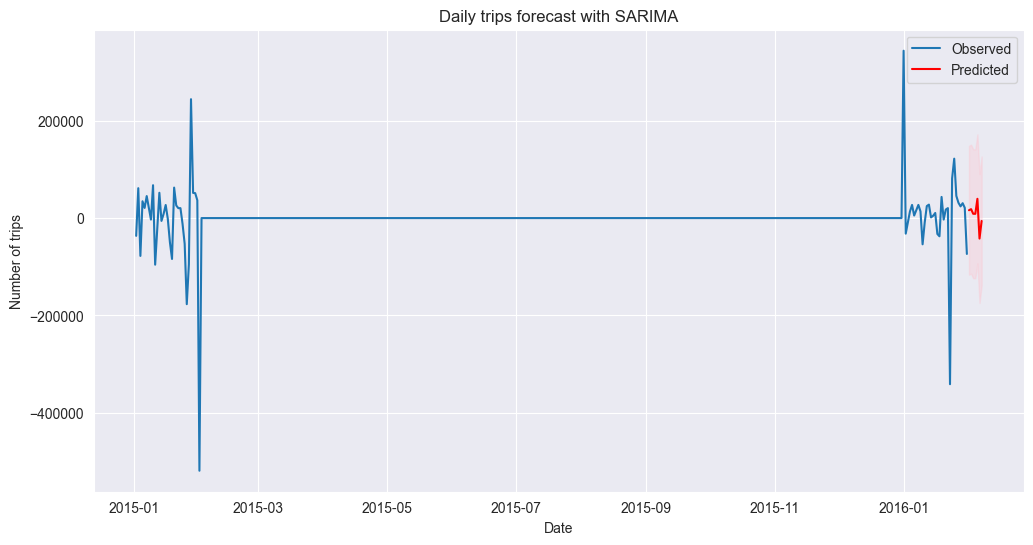

In [38]:
import statsmodels.api as sm

# SARIMA model with weekly seasonality
model = sm.tsa.statespace.SARIMAX(ts_daily_trips_diff, order=(1,1,1), seasonal_order=(1,1,1,7))
model_fit = model.fit()

# Model summary
print(model_fit.summary())

# Prediction
forecast = model_fit.get_forecast(steps=7)
forecast_ci = forecast.conf_int()

# Visualization
plt.figure(figsize=(12,6))
plt.plot(ts_daily_trips_diff, label='Observed')
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean.values, label='Predicted', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:,0], forecast_ci.iloc[:,1], color='pink', alpha=0.3)
plt.title('Daily trips forecast with SARIMA')
plt.xlabel('Date')
plt.ylabel('Number of trips')
plt.legend()
plt.show()
